# Final version of implementation

# Environment model and elementary methods and funcitons

## implementing environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [ ]:
class Student():
    def __init__(self):
        pass

    def get_reward(self,action):
        if action == 0:
            score = truncnorm(a=(0-40)/40, b=(100-40)/40, loc=40, scale=40).rvs(size=1).astype(int)
        elif action == 1:
            score = truncnorm(a=(0-60)/10, b=(100-60)/10, loc=60, scale=10).rvs(size=1).astype(int)
        else:
            score = truncnorm(a=(0-50)/20, b=(100-50)/20, loc=50, scale=20).rvs(size=1).astype(int)

        return score

In [ ]:
class Environment:
    def __init__(self, student):
        self.student = student

    def calc_reward(self,action):
        reward = self.student.get_reward(action)
        return reward

## Implementing Gradient bandit

In [ ]:
class Gradient_Bandit_agent:
    # def __init__(self, env, learning_rate, No_Arms):
    def __init__(self, learning_rate, No_Arms):
        self.n_arms = No_Arms
        self.preferences = np.zeros(No_Arms)
        self.learning_rate = learning_rate
        self.Ntrial = 0
        self.r_bar = 0


    def softmax(self, preferences):
        exp_preferences = np.exp(preferences)
        sum_exp_preferences = np.sum(exp_preferences)
        softmax_vals = exp_preferences / sum_exp_preferences
        return softmax_vals


    def take_action(self):
        softmax_vals = self.softmax(self.preferences)
        action = np.random.choice(np.arange(self.n_arms), p=softmax_vals)
        return action


    def update_policy(self,reward,action):
        self.Ntrial += 1
        pi = self.softmax(self.preferences)

        if self.Ntrial == 1:
            self.r_bar = reward

        for i in range(self.n_arms):
            if i == action:
                self.preferences[i] = self.preferences[i] + self.learning_rate * (reward - self.r_bar) * (1 - pi[i])
            else:
                self.preferences[i] = self.preferences[i] - self.learning_rate * (reward - self.r_bar) * pi[i]

        self.r_bar = self.r_bar + (reward - self.r_bar) / self.Ntrial



## simulation function
it takes env, agent ,and number of trials and perform the learning loop for the specified agent for the specified number of trials

In [ ]:
def run_simulation(env,agent,number_trial):
    action_seq = []
    reward_seq = []
    for trial in range(number_trial):
        action = agent.take_action()
        reward  = env.calc_reward(action)[0]
        action_seq.append(action)
        reward_seq.append(reward)
        agent.update_policy(reward,action)
    return [action_seq , reward_seq ]


# Performing gradient bandit and plotting reward and regret

## expected reward analysis

In [ ]:
# to make results reproducible
np.random.seed(100)

number_of_school = 10
number_trial = 52 * 100
GB_results_dic = {} # storing results for different learning rates

No_Arms = 3

for learning_rate in [0.1 , 0.01 , 0.001]:
    GB_results = []
    for i in range(number_of_school):
        # initializing env and agent
        agent = Gradient_Bandit_agent(learning_rate, No_Arms)
        env = Environment(Student()) # creating environment

        # running simulation
        [action_seq , reward_seq] = run_simulation(env,agent,number_trial)
        GB_results.append([action_seq , reward_seq])

    GB_results_dic[learning_rate] = GB_results


In [ ]:
def calculate_expected_reward(result,number_of_school,number_trial):
    R_expected = np.zeros([number_trial,1])
    R_std = np.zeros([number_trial,1])
    for horizon in range(number_trial):
        a = []
        for i in range(number_of_school):
            a.append(result[i][1][horizon])
            R_expected[horizon] = np.mean(a)
            R_std[horizon] = np.std(a)
    return [R_expected,R_std]

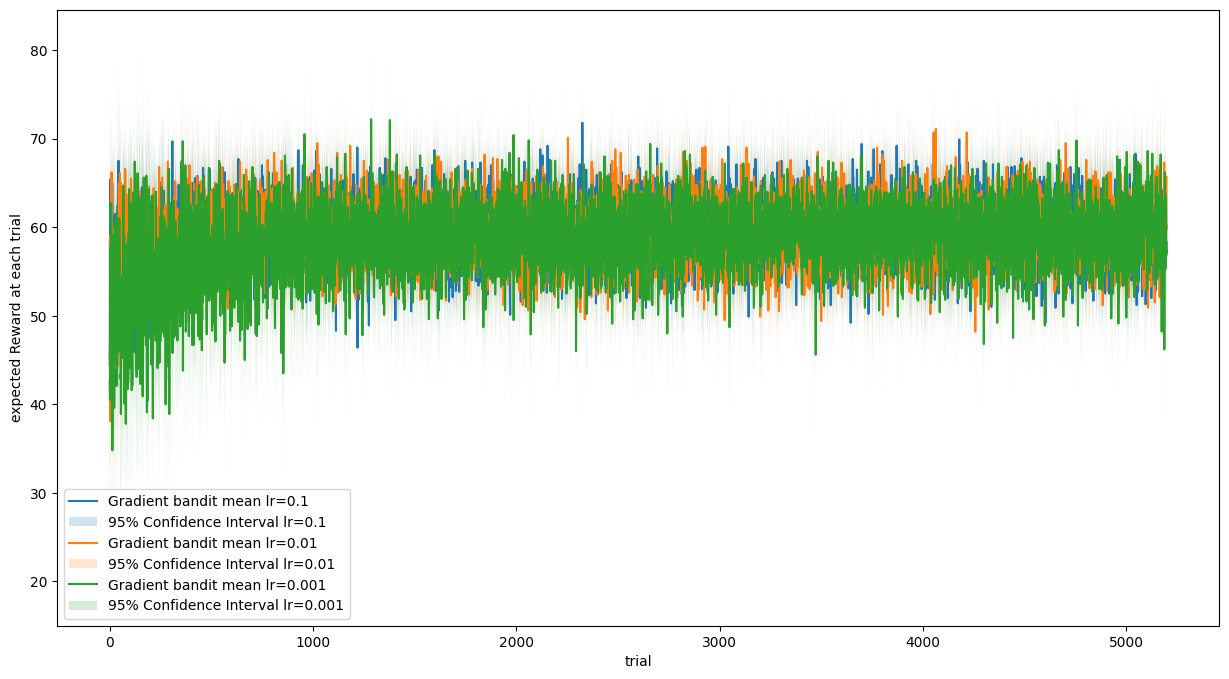

In [ ]:
plt.figure(figsize=(15,8))

for learning_rate in [0.1 , 0.01 , 0.001]:
    GB_results = GB_results_dic[learning_rate]
    [gb_R_expected,gb_R_std] = calculate_expected_reward(GB_results,number_of_school,number_trial)

    x = np.arange(number_trial)
    gb_R_expected = gb_R_expected.reshape((-1,))
    gb_R_std = gb_R_std.reshape((-1,))

    plt.plot(gb_R_expected,label='Gradient bandit mean lr='+ str(learning_rate))

    plt.fill_between( x, gb_R_expected - 1.96*gb_R_std / np.sqrt(10), gb_R_expected + 1.96*gb_R_std/np.sqrt(10), alpha=0.2, label='95% Confidence Interval lr='+ str(learning_rate))


plt.legend()
plt.xlabel("trial")
plt.ylabel("expected Reward at each trial")
plt.show()

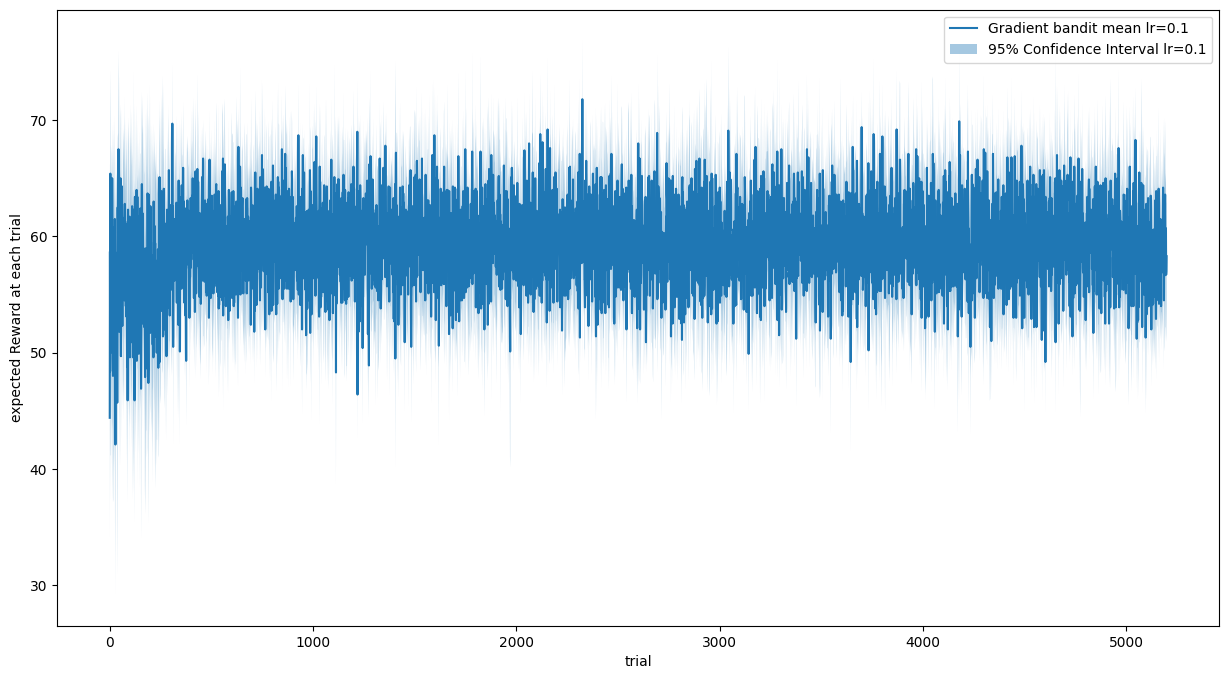

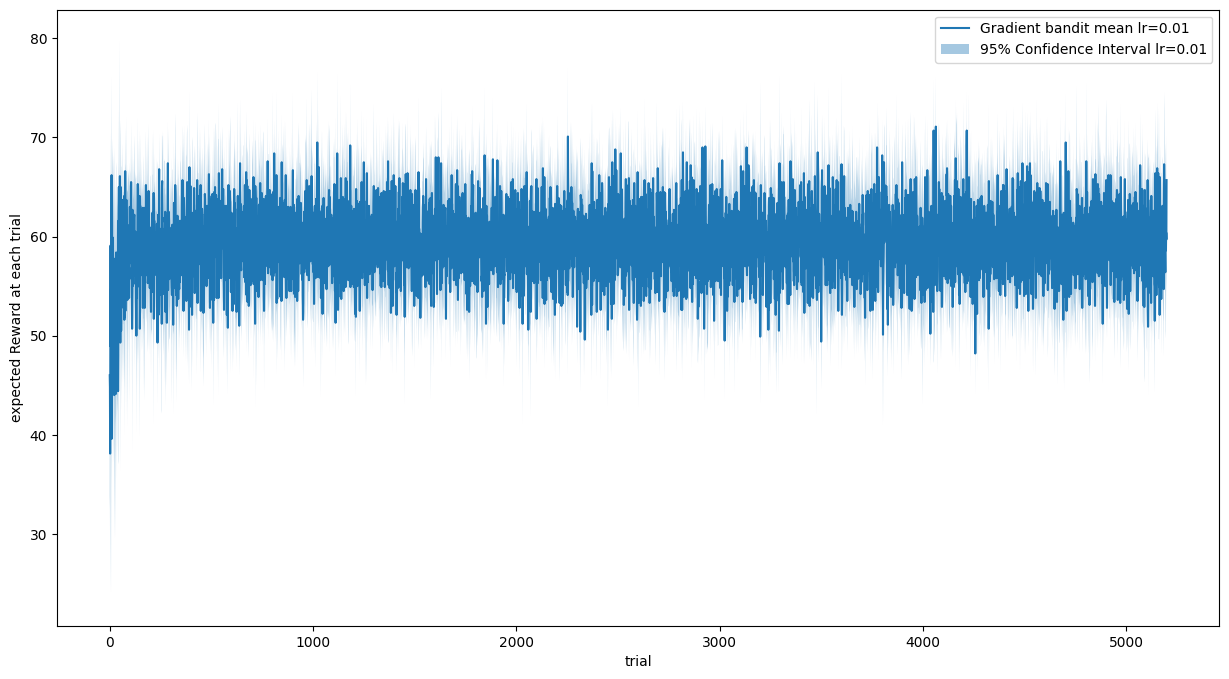

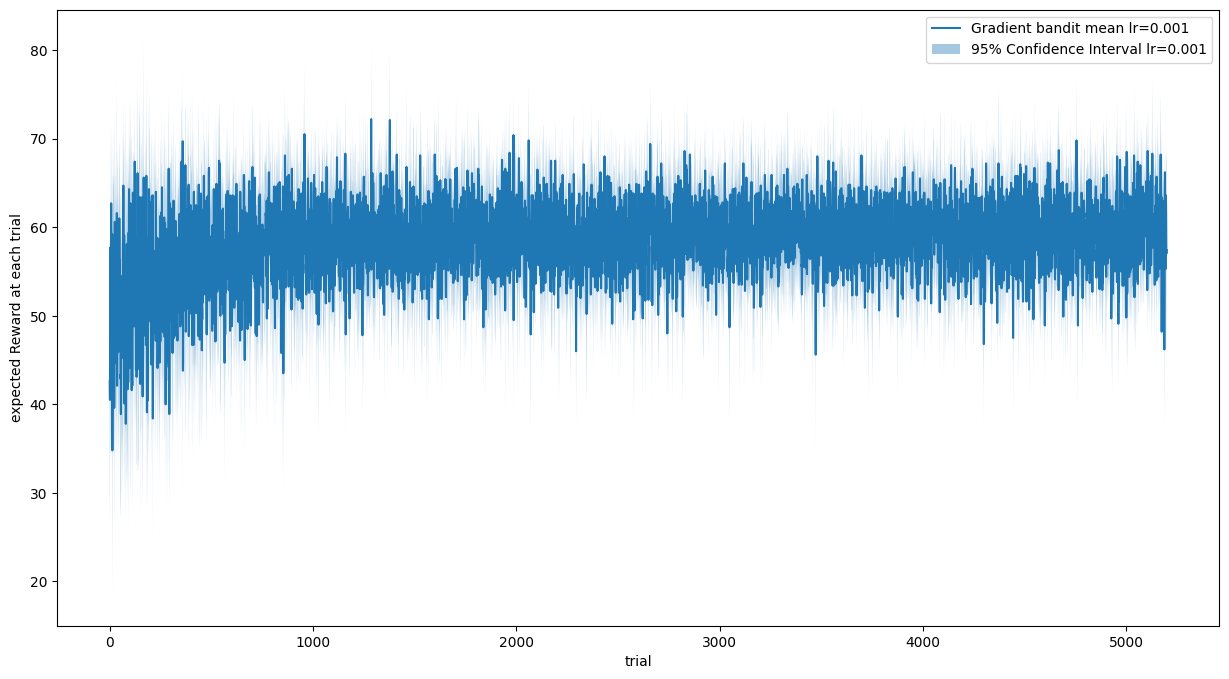

In [ ]:
for learning_rate in [0.1 , 0.01 , 0.001]:
    plt.figure(figsize=(15,8))
    GB_results = GB_results_dic[learning_rate]
    [gb_R_expected,gb_R_std] = calculate_expected_reward(GB_results,number_of_school,number_trial)

    x = np.arange(number_trial)
    gb_R_expected = gb_R_expected.reshape((-1,))
    gb_R_std = gb_R_std.reshape((-1,))

    plt.plot(gb_R_expected,label='Gradient bandit mean lr='+ str(learning_rate))

    plt.fill_between( x, gb_R_expected - 1.96*gb_R_std/np.sqrt(10), gb_R_expected + 1.96*gb_R_std/np.sqrt(10), alpha=0.4, label='95% Confidence Interval lr='+ str(learning_rate))
    plt.legend()
    plt.xlabel("trial")
    plt.ylabel("expected Reward at each trial")
    plt.show()

## Regret analysis

In [ ]:
real_q = np.array([40 , 60 , 50 ])
real_q = real_q.reshape([-1,1])
q_opt = 60
delta = q_opt - real_q

def calculate_regret(result):
    regret_mean = np.zeros([number_trial,1])
    regret_std = np.zeros([number_trial,1])

    summer = np.zeros([number_of_school,1])
    for horizon in range(number_trial): # finding the regret for this horizon
        for sher in range(number_of_school):
            action_seq = result[sher][0]
            ac = action_seq[horizon]
            summer[sher] +=  delta[ac]
        regret_mean[horizon] = np.mean(summer)
        regret_std[horizon] = np.std(summer)

    return [regret_mean,regret_std]


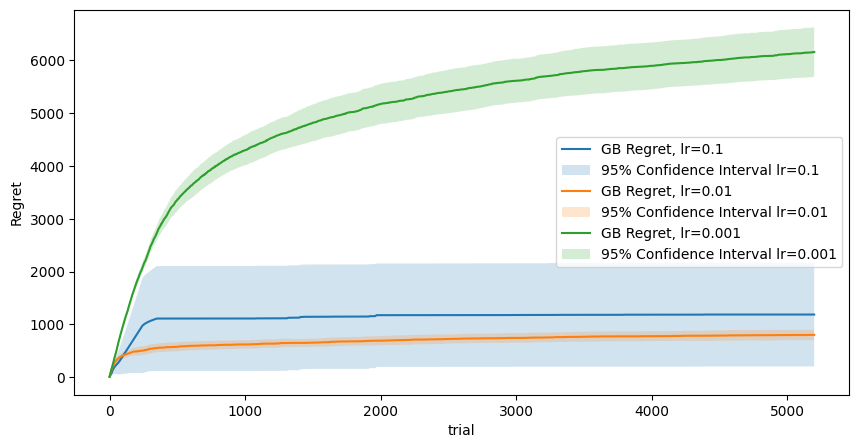

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
x = np.arange(5200)

for learning_rate in  [0.1 , 0.01 , 0.001]:
    GB_results = GB_results_dic[learning_rate]
    [regret_mean,regret_std] = calculate_regret(GB_results)
    regret_mean = regret_mean.reshape((-1,))
    regret_std = regret_std.reshape((-1,))
    plt.plot(regret_mean,label='GB Regret, lr='+ str(learning_rate))
    plt.fill_between( x, regret_mean - 1.96*regret_std/np.sqrt(10), regret_mean + 1.96*regret_std/np.sqrt(10), alpha=0.2, label='95% Confidence Interval lr='+ str(learning_rate))


plt.legend()
plt.xlabel("trial")
plt.ylabel("Regret")
plt.legend()
plt.show()